# Problem 7.1

In [99]:
import glob
import os
import warnings
import time
from numba import jit
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats as st

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

In [55]:
# The directory containing daytime data
data_dir_day = '/Users/elenaperry/Dropbox/Caltech/bebi103/Cassiopea_Pulsation/day'

# Glob string for day images
im_glob_day = os.path.join(data_dir_day, '*.TIF')

# The directory containing nighttime data
data_dir_night = '/Users/elenaperry/Dropbox/Caltech/bebi103/Cassiopea_Pulsation/night'

# Glob string for night images
im_glob_night = os.path.join(data_dir_night, '*.TIF')

In [6]:
# We used plt.ginput(100) to select vertices for each jellyfish's ROI
verts1 = np.array([(35.863636363636388, 107.22727272727269),
 (173.59090909090912, 111.31818181818176),
 (168.13636363636368, 223.13636363636363),
 (34.500000000000014, 216.31818181818181)])
 
verts2 = np.array([(185.86363636363643, 100.40909090909088),
 (338.59090909090918, 111.31818181818176),
 (330.40909090909099, 232.68181818181813),
 (185.86363636363643, 224.5)])
 
verts3 = np.array([(349.50000000000006, 99.045454545454504),
 (498.13636363636374, 100.40909090909088),
 (495.40909090909099, 236.77272727272725),
 (348.13636363636368, 238.13636363636363)])
 
verts4 = np.array([(504.9545454545455, 90.863636363636317),
 (635.86363636363649, 97.68181818181813),
 (634.50000000000011, 244.95454545454544),
 (506.31818181818187, 239.5)])

verts5 = np.array([(38.590909090909108, 232.68181818181813),
 (173.59090909090912, 239.5),
 (169.50000000000006, 379.95454545454544),
 (34.500000000000014, 363.59090909090907)])

verts6 = np.array([(184.50000000000006, 250.40909090909088),
 (335.86363636363643, 253.13636363636363),
 (331.77272727272731, 392.22727272727275),
 (177.68181818181824, 386.77272727272725)])

verts7 = np.array([(345.40909090909099, 249.0454545454545),
 (492.68181818181824, 250.40909090909088),
 (485.86363636363649, 393.59090909090907),
 (345.40909090909099, 389.5)])

verts8 = np.array([(502.22727272727275, 250.40909090909088),
 (633.13636363636374, 255.86363636363632),
 (633.13636363636374, 393.59090909090907),
 (503.59090909090912, 393.59090909090907)])

all_verts = np.array([verts1, verts2, verts3, verts4,
                  verts5, verts6, verts7, verts8])

In [7]:
def local_min(x, y):
    """
    Fit three points to quadratic and return location of maximum or minimum.
    """
    a, b, c = np.polyfit(x, y, 2)
    x_max = -b / 2 / a
    return x_max, a*x_max**2 + b*x_max + c

In [41]:
def load_roi(fname, roi_bbox=None):
    """
    To be used as load_func in skimage.io.ImageCollection.
    Returns region bounding ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[0,:,:]
    else:
        return skimage.io.imread(fname)[0,:,:][roi_bbox]

def intercontraction_times_slow(verts, im_glob, im_shape=(480,640), fps=15):
    """
    Calculate intercontraction times (seconds) for one jellyfish.
    Returns array of time stamps for the images, array of total 
    intensities rescaled to go from -1 to 1, array of times of 
    peak maxima, array of peak maxima, and array of intercontraction 
    times.
    """
    # Unpack image dimensions
    y_dim, x_dim = im_shape
    
    # Define ROI
    roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, y_dim, x_dim)

    # Load image collection
    ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                    load_func=load_roi, roi_bbox=roi_bbox)
    
    # Generate timestamps for the images
    t = np.arange(0, len(ic)) / fps

    # Set up Numpy array to store total pixel intensity
    total_int = np.empty(len(t))

    # Look through and compute total intensity in the ROI
    for i, im in enumerate(ic):
        total_int[i] = ic[i][roi_box].sum()

    # Subtract the mean and rescale the data to go from -1 to 1
    total_int -= total_int.mean()
    total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                    * (total_int - total_int.max())

    # Find up and down crossing indices
    up_crossing_inds = np.where(
        np.logical_and(total_int[:-1] < 0, total_int[1:] >= 0))[0]
    down_crossing_inds = np.where(
        np.logical_and(total_int[:-1] > 0, total_int[1:] <= 0))[0] + 1

    # Make sure upcrossing are first
    if down_crossing_inds[0] < up_crossing_inds[0]:
        down_crossing_inds = down_crossing_inds[1:]

    # Make sure downcrossing last
    if up_crossing_inds[-1] > down_crossing_inds[-1]:
        up_crossing_inds = up_crossing_inds[:-1]

    # Find maxima
    t_peaks = np.empty(len(up_crossing_inds))
    peaks = np.empty_like(t_peaks)
    for i, uc in enumerate(up_crossing_inds):
        ind = uc + np.argmax(total_int[uc:down_crossing_inds[i]+1])
        t_peaks[i], peaks[i] = local_min(t[ind-1:ind+2], total_int[ind-1:ind+2])

    # Intercontractions times
    t_int = np.diff(t_peaks)
    
    return t, total_int, t_peaks, peaks, t_int

In [56]:
def get_roi(verts, im_glob, im_shape=(480,640)):
    """
    Returns as a Numpy array the smallest square subimage 
    that completely contains the ROI.
    """
    # Unpack image dimensions
    y_dim, x_dim = im_shape
    
    # Define ROI
    roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, y_dim, x_dim)
    
    # Load images and store only the region that bounds the ROI
    im_list = glob.glob(im_glob)
    ims = [None] * len(im_list)
    for i in range(len(im_list)):
        ims[i] = scipy.ndimage.imread(im_list[i])[roi_bbox]

    ims = np.array(ims) 
    return ims, roi, roi_bbox, roi_box

@jit
def intercontraction_times_fast(ims, roi_box, fps=15):
    """
    Calculate intercontraction times using the power of Numba
    to speed it up ~500x.
    """
    # Generate timestamps for the images
    t = np.arange(0, len(ims)) / fps

    # Set up Numpy array to store total pixel intensity
    total_int = np.empty(len(t))

    # Look through and compute total intensity in the ROI
    for i in range(len(ims)):
        total_int[i] = ims[i][roi_box].sum()

    # Subtract the mean and rescale the data to go from -1 to 1
    total_int -= total_int.mean()
    total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                    * (total_int - total_int.max())

    # Find up and down crossing indices
    up_crossing_inds = np.where(
        np.logical_and(total_int[:-1] < 0, total_int[1:] >= 0))[0]
    down_crossing_inds = np.where(
        np.logical_and(total_int[:-1] > 0, total_int[1:] <= 0))[0] + 1

    # Make sure upcrossing are first
    if down_crossing_inds[0] < up_crossing_inds[0]:
        down_crossing_inds = down_crossing_inds[1:]

    # Make sure downcrossing last
    if up_crossing_inds[-1] > down_crossing_inds[-1]:
        up_crossing_inds = up_crossing_inds[:-1]

    # Find maxima
    t_peaks = np.empty(len(up_crossing_inds))
    peaks = np.empty_like(t_peaks)
    for i, uc in enumerate(up_crossing_inds):
        ind = uc + np.argmax(total_int[uc:down_crossing_inds[i]+1])
        t_peaks[i], peaks[i] = local_min(t[ind-1:ind+2], total_int[ind-1:ind+2])

    # Intercontractions times
    t_int = np.diff(t_peaks)
    
    return t, total_int, t_peaks, peaks, t_int

In [46]:
start = time.time()
t1, total_int1, t_peaks1, peaks1, t_int1 = intercontraction_times_slow(all_verts[6], im_glob_day)
print('intercontraction_times_slow took ' + str(time.time()-start) + ' seconds')

intercontraction_times_slow took 745.6605441570282 seconds


In [57]:
start = time.time()
ims, roi, roi_bbox, roi_box = get_roi(all_verts[6], im_glob_day)
print('get_roi took ' + str(time.time()-start) + ' seconds')

start = time.time()
t2, total_int2, t_peaks2, peaks2, t_int2 = intercontraction_times_fast(ims, roi_box)
print('intercontraction_times_fast took ' + str(time.time()-start) + ' seconds')

get_roi took 25.83569312095642 seconds
intercontraction_times_fast took 1.296436071395874 seconds


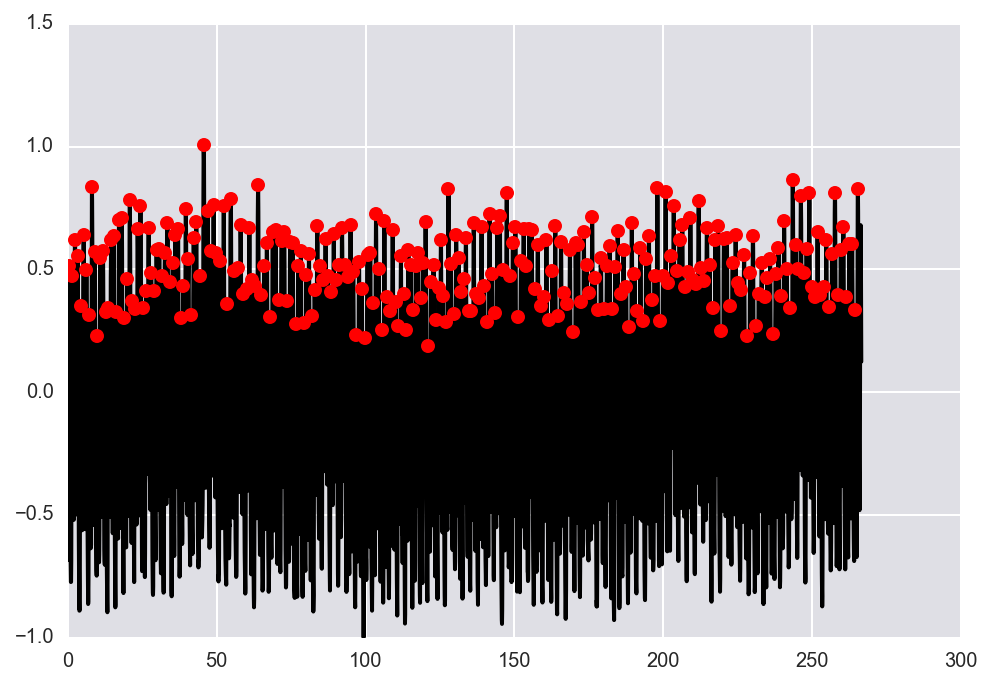

In [77]:
plt.plot(t1, total_int1, color='k')
plt.plot(t_peaks1, peaks1, marker='o', linestyle='None', color='r')

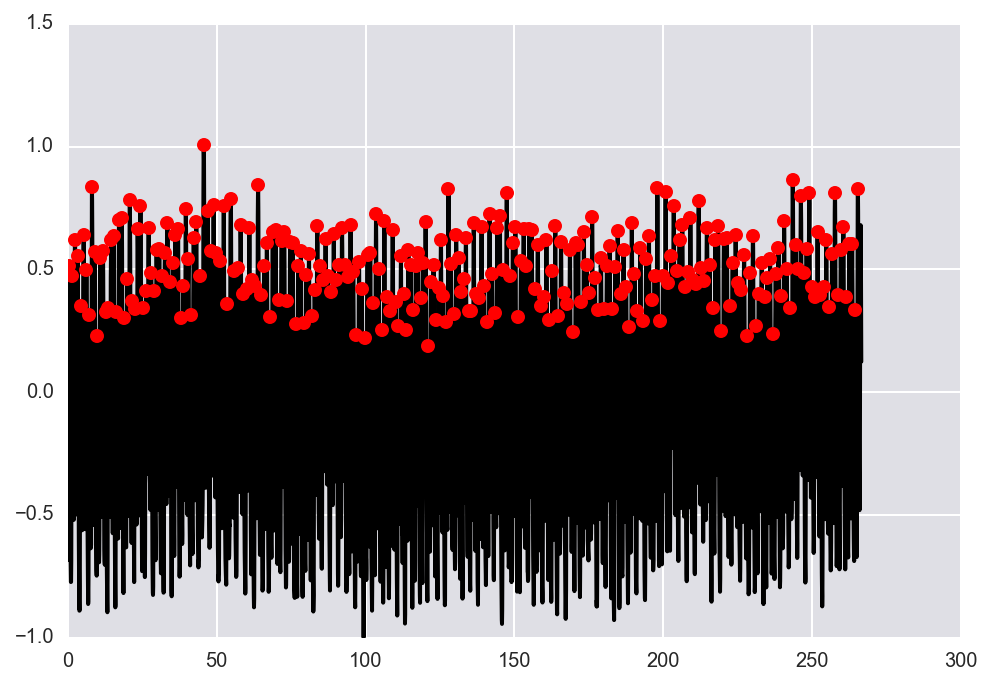

In [78]:
plt.plot(t2, total_int2, color='k')
plt.plot(t_peaks2, peaks2, marker='o', linestyle='None', color='r')

In [70]:
# Get the daytime raw data and intercontraction times for all 8 jellyfish
t_arr_day = np.empty((len(all_verts), 4000))
total_int_arr_day = np.empty((len(all_verts), 4000))
t_peaks_list_day = []
peaks_list_day = []
t_int_list_day = [] 

for i in range(len(all_verts)):
    ims, roi, roi_bbox, roi_box = get_roi(all_verts[i], im_glob_day)
    t, total_int, t_peaks, peaks, t_int = intercontraction_times_fast(ims, roi_box)
    t_arr_day[i,:] = t
    total_int_arr_day[i,:] = total_int
    t_peaks_list_day.append(t_peaks)
    peaks_list_day.append(peaks)
    t_int_list_day.append(t_int)

# Get the nighttime raw data and intercontraction times for all 8 jellyfish
t_arr_night = np.empty((len(all_verts), 4000))
total_int_arr_night = np.empty((len(all_verts), 4000))
t_peaks_list_night = []
peaks_list_night = []
t_int_list_night = []

for i in range(len(all_verts)):
    ims, roi, roi_bbox, roi_box = get_roi(all_verts[i], im_glob_night)
    t, total_int, t_peaks, peaks, t_int = intercontraction_times_fast(ims, roi_box)
    t_arr_night[i,:] = t
    total_int_arr_night[i,:] = total_int
    t_peaks_list_night.append(t_peaks)
    peaks_list_night.append(peaks)
    t_int_list_night.append(t_int)

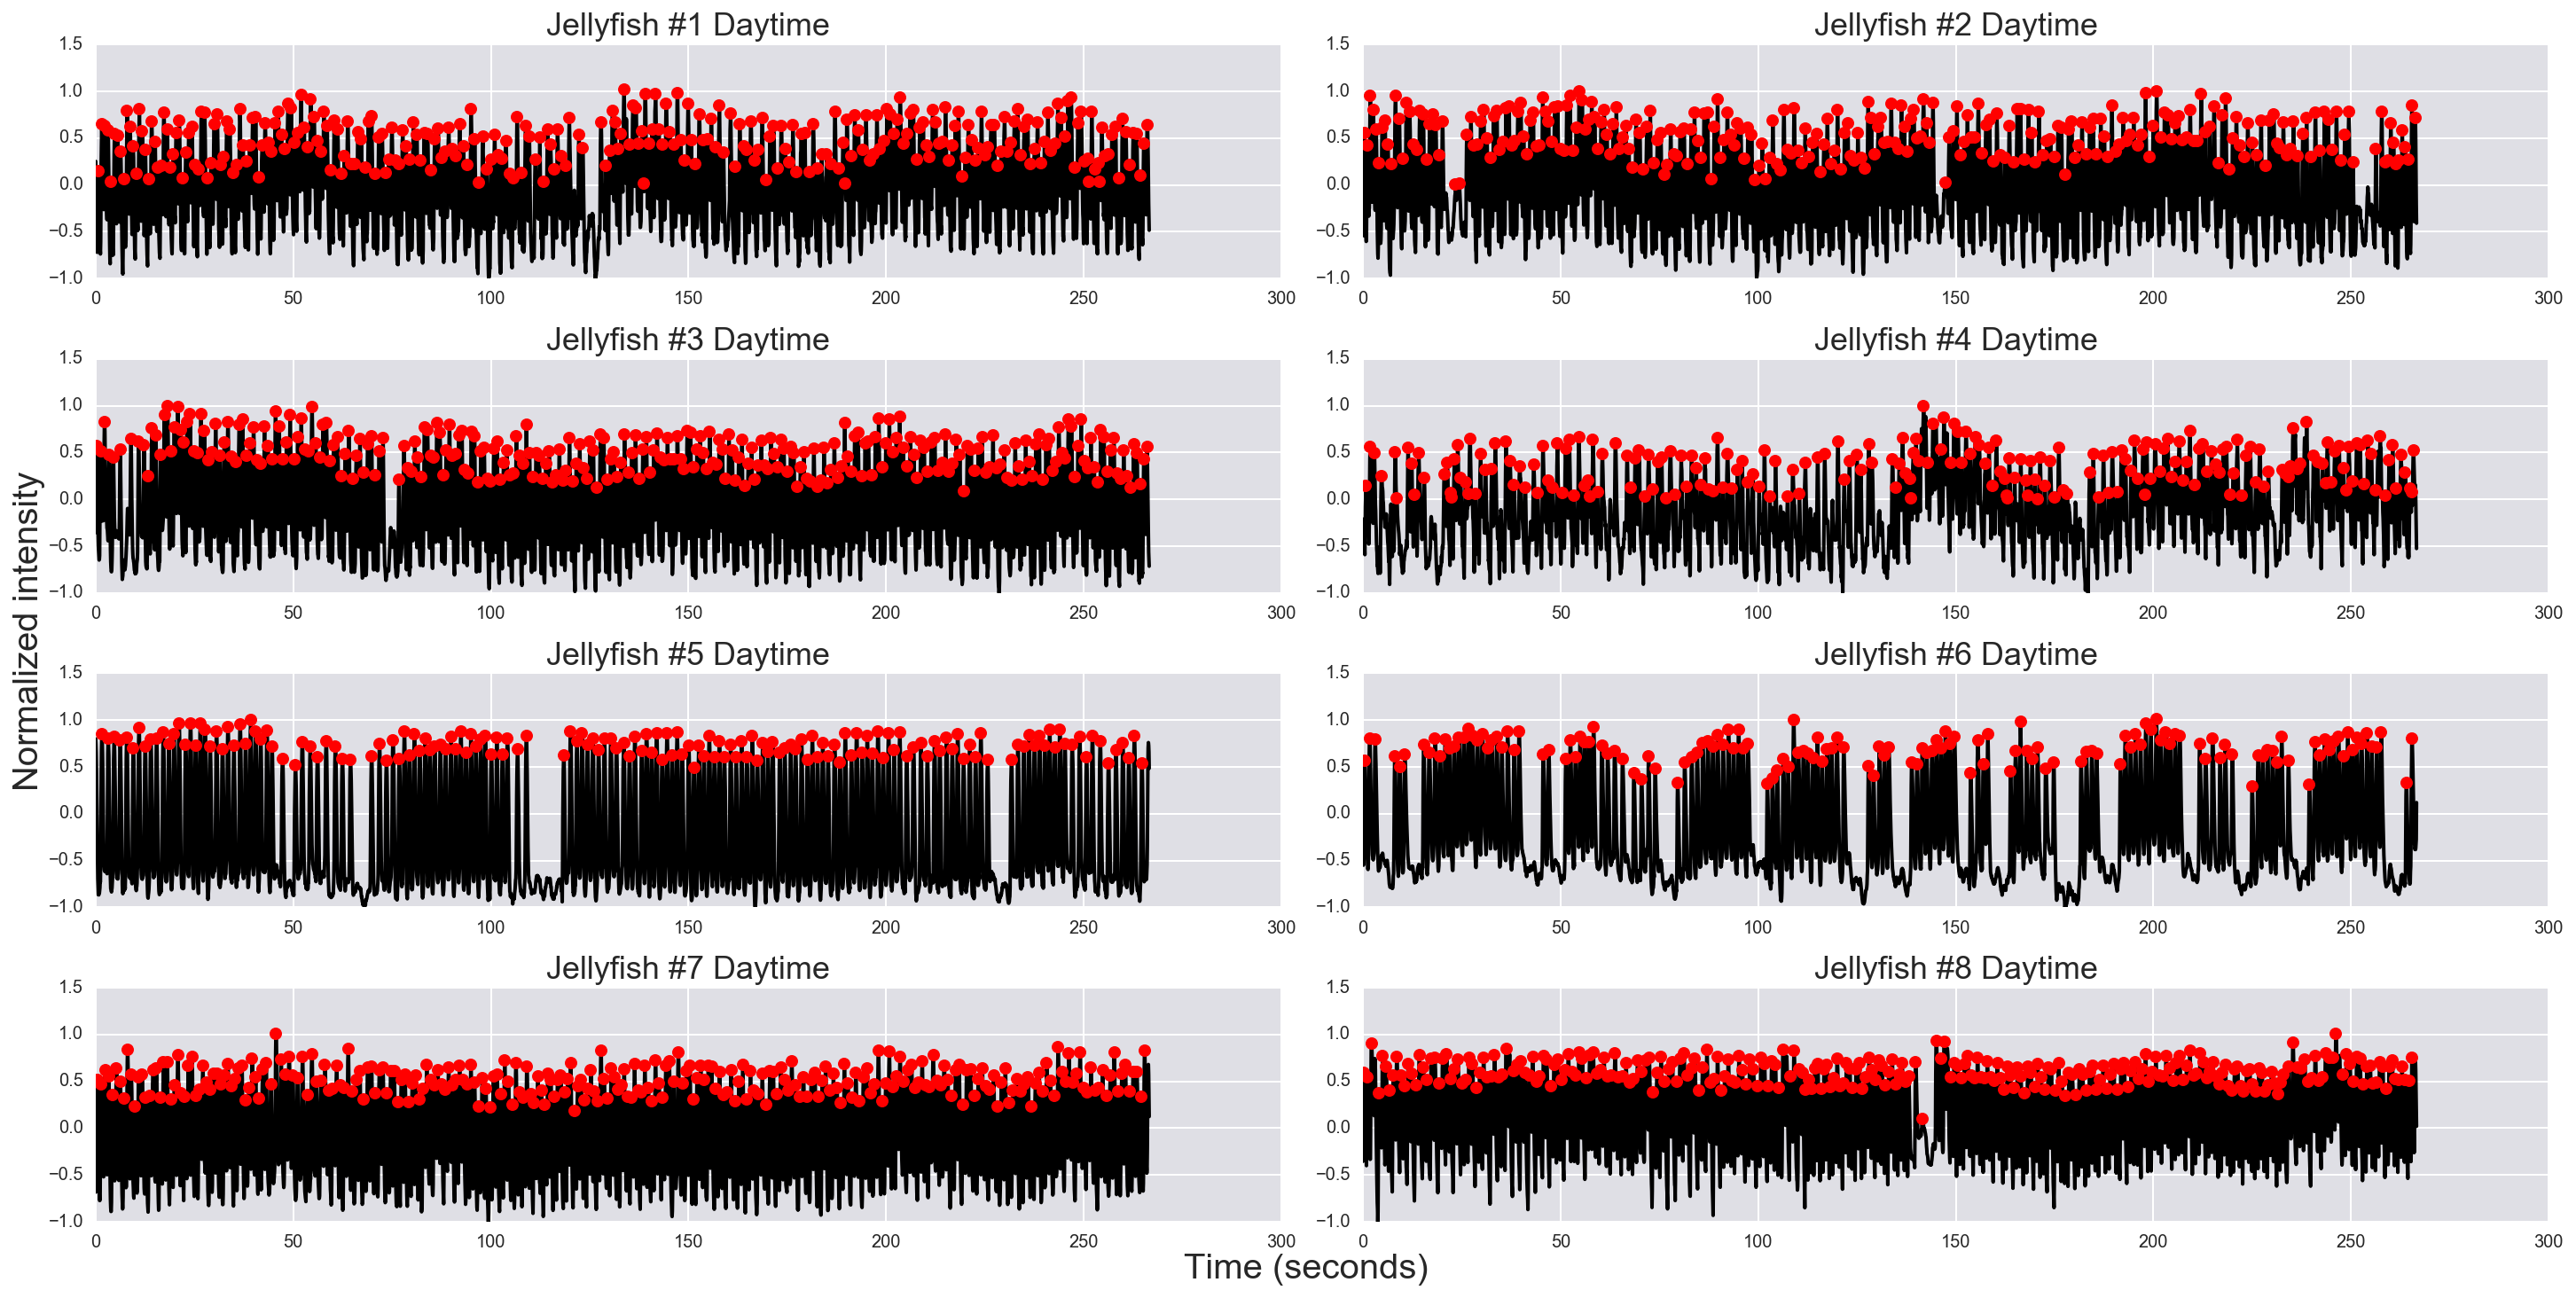

In [88]:
# Make plots for daytime activity of each jellyfish
f = plt.figure(figsize=(20,10))
plt.subplot(4,2,1)
plt.plot(t_arr_day[0], total_int_arr_day[0], color='k')
plt.plot(t_peaks_list_day[0], peaks_list_day[0], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #1 Daytime')

plt.subplot(4,2,2)
plt.plot(t_arr_day[1], total_int_arr_day[1], color='k')
plt.plot(t_peaks_list_day[1], peaks_list_day[1], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #2 Daytime')

plt.subplot(4,2,3)
plt.plot(t_arr_day[2], total_int_arr_day[2], color='k')
plt.plot(t_peaks_list_day[2], peaks_list_day[2], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #3 Daytime')

plt.subplot(4,2,4)
plt.plot(t_arr_day[3], total_int_arr_day[3], color='k')
plt.plot(t_peaks_list_day[3], peaks_list_day[3], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #4 Daytime')

plt.subplot(4,2,5)
plt.plot(t_arr_day[4], total_int_arr_day[4], color='k')
plt.plot(t_peaks_list_day[4], peaks_list_day[4], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #5 Daytime')

plt.subplot(4,2,6)
plt.plot(t_arr_day[5], total_int_arr_day[5], color='k')
plt.plot(t_peaks_list_day[5], peaks_list_day[5], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #6 Daytime')

plt.subplot(4,2,7)
plt.plot(t_arr_day[6], total_int_arr_day[6], color='k')
plt.plot(t_peaks_list_day[6], peaks_list_day[6], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #7 Daytime')

plt.subplot(4,2,8)
plt.plot(t_arr_day[7], total_int_arr_day[7], color='k')
plt.plot(t_peaks_list_day[7], peaks_list_day[7], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #8 Daytime')

# Set common labels
f.text(0.5, 0.0, 'Time (seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

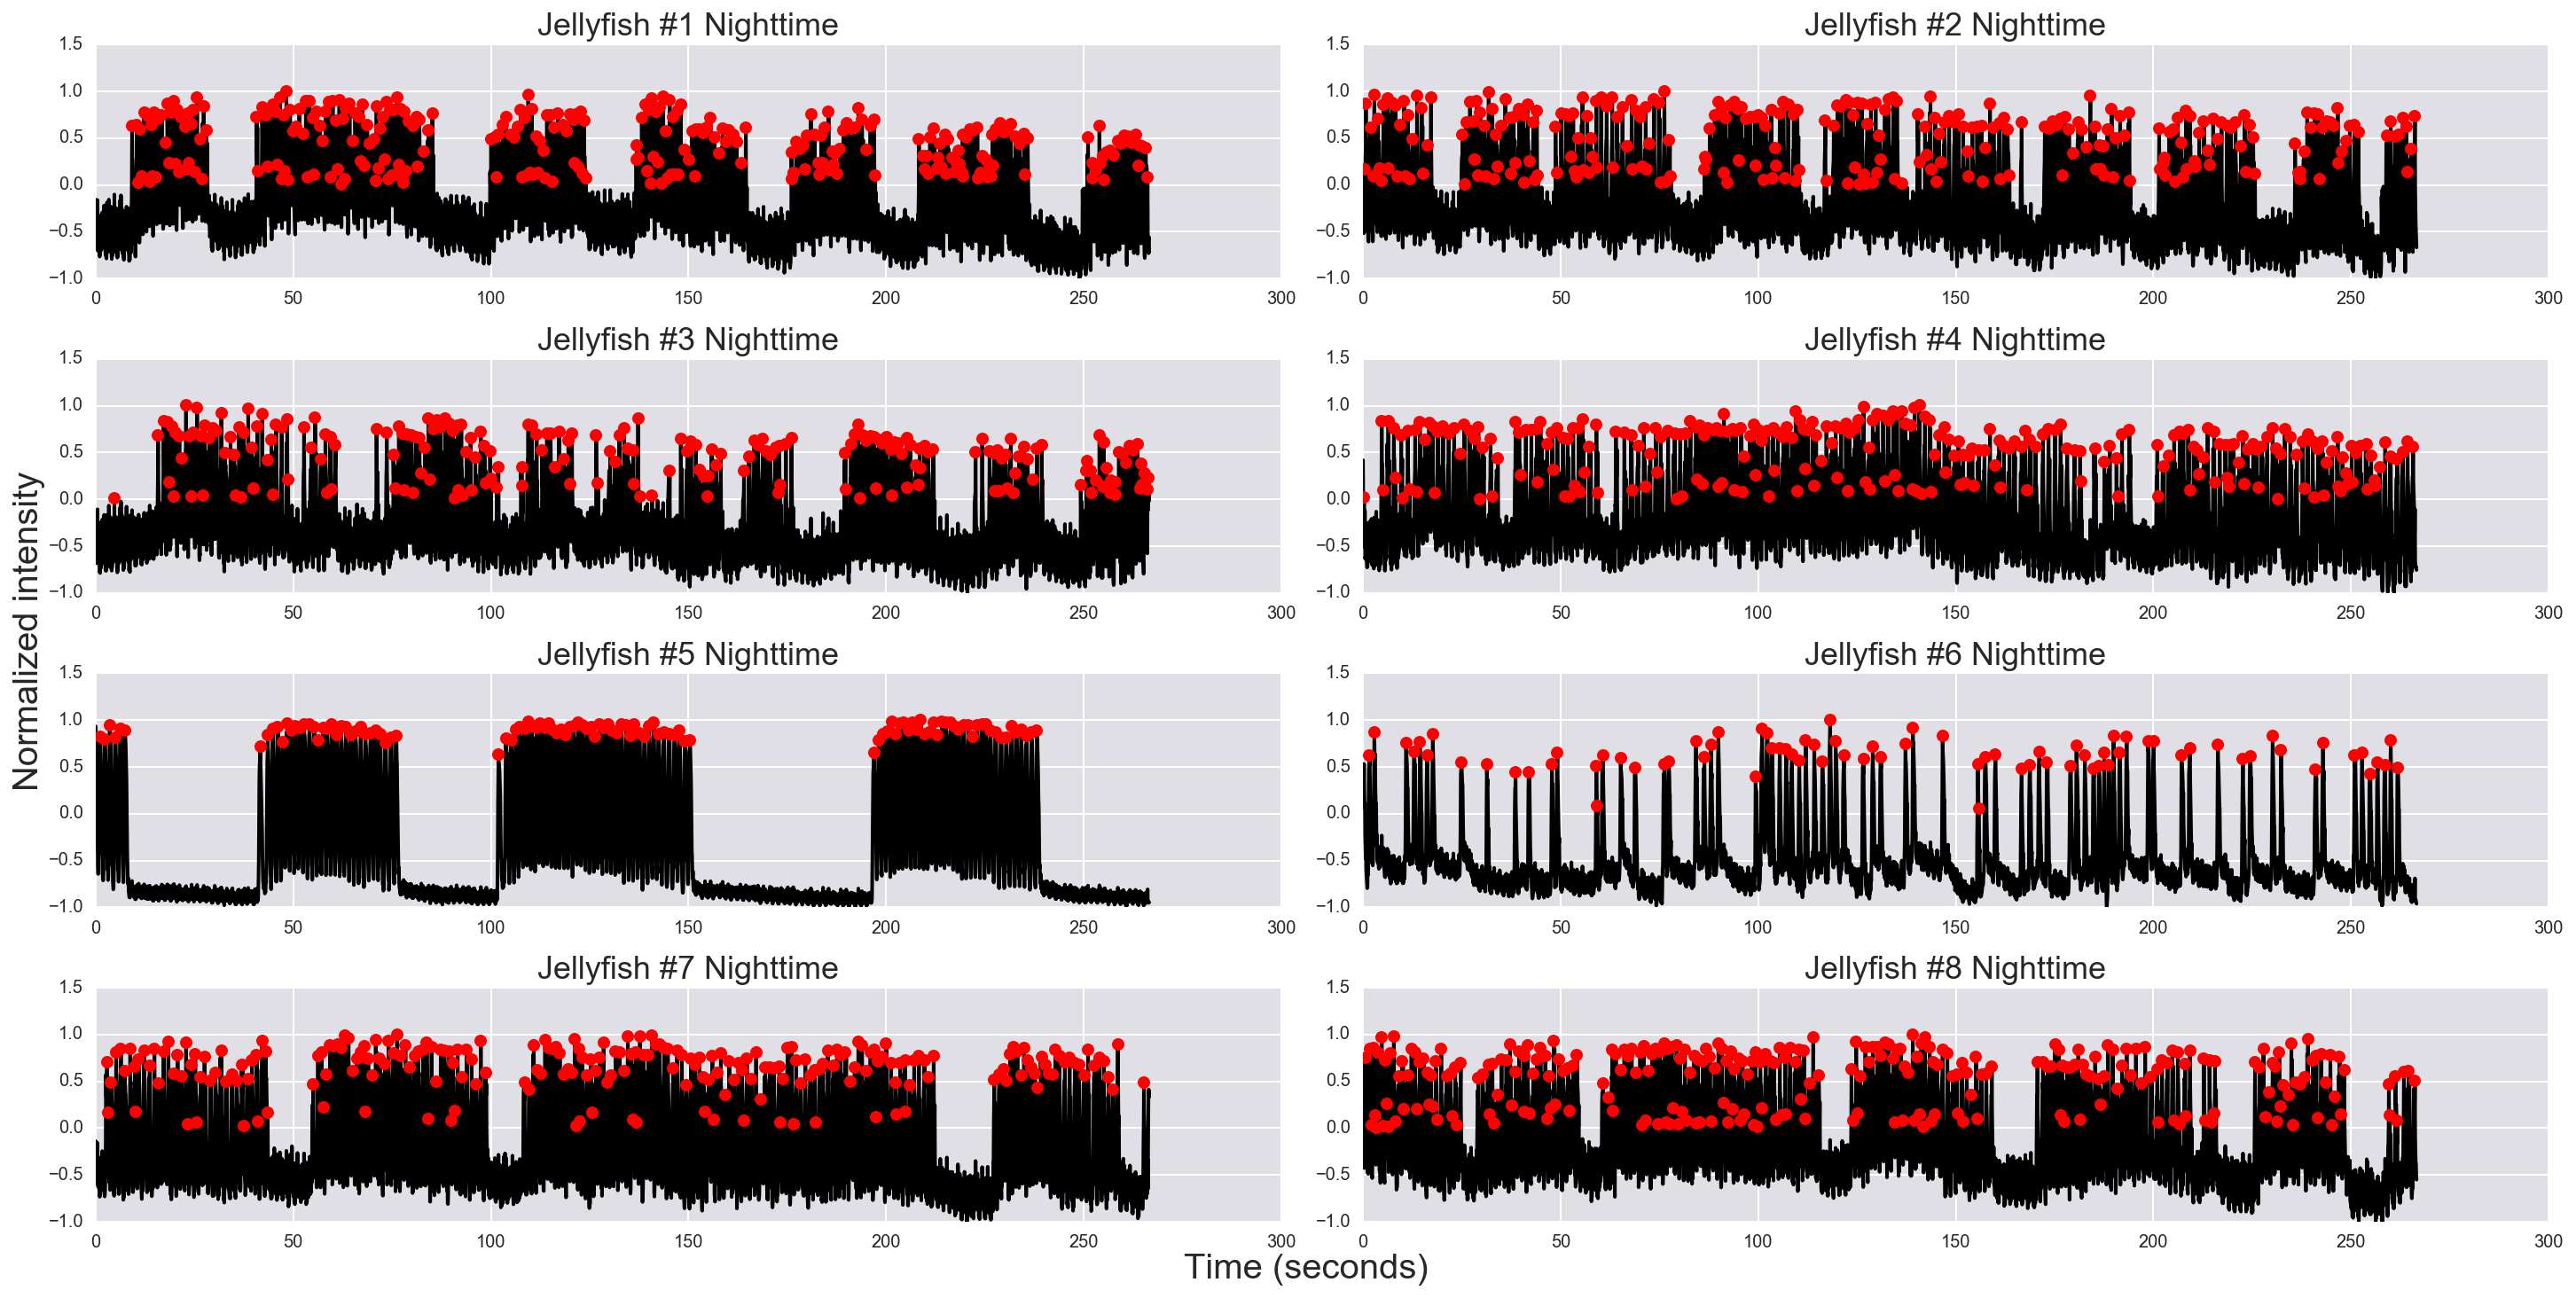

In [91]:
# Make plots for nighttime activity of each jellyfish
f = plt.figure(figsize=(20,10))
plt.subplot(4,2,1)
plt.plot(t_arr_night[0], total_int_arr_night[0], color='k')
plt.plot(t_peaks_list_night[0], peaks_list_night[0], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #1 Nighttime')

plt.subplot(4,2,2)
plt.plot(t_arr_night[1], total_int_arr_night[1], color='k')
plt.plot(t_peaks_list_night[1], peaks_list_night[1], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #2 Nighttime')

plt.subplot(4,2,3)
plt.plot(t_arr_night[2], total_int_arr_night[2], color='k')
plt.plot(t_peaks_list_night[2], peaks_list_night[2], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #3 Nighttime')

plt.subplot(4,2,4)
plt.plot(t_arr_night[3], total_int_arr_night[3], color='k')
plt.plot(t_peaks_list_night[3], peaks_list_night[3], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #4 Nighttime')

plt.subplot(4,2,5)
plt.plot(t_arr_night[4], total_int_arr_night[4], color='k')
plt.plot(t_peaks_list_night[4], peaks_list_night[4], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #5 Nighttime')

plt.subplot(4,2,6)
plt.plot(t_arr_night[5], total_int_arr_night[5], color='k')
plt.plot(t_peaks_list_night[5], peaks_list_night[5], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #6 Nighttime')

plt.subplot(4,2,7)
plt.plot(t_arr_night[6], total_int_arr_night[6], color='k')
plt.plot(t_peaks_list_night[6], peaks_list_night[6], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #7 Nighttime')

plt.subplot(4,2,8)
plt.plot(t_arr_night[7], total_int_arr_night[7], color='k')
plt.plot(t_peaks_list_night[7], peaks_list_night[7], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #8 Nighttime')

# Set common labels
f.text(0.5, 0.0, 'Time (seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

In [92]:
# Calculate mean of means to compare daytime and nighttime intercontraction times
mean_int_day = np.empty(len(all_verts))
mean_int_night = np.empty(len(all_verts))
for i in range(len(all_verts)):
    mean_int_day[i] = np.mean(t_int_list_day[i])
    mean_int_night[i] = np.mean(t_int_list_night[i])

In [142]:
df_cauchy = pd.DataFrame(columns=['Jellyfish', 'DayNight', 'IntTime'])
jellyfish_nums = [1, 2, 3, 4, 5, 6, 7, 8]
df_cauchy['Jellyfish'] = list(itertools.chain.from_iterable([[jellyfish_nums[i]] 
                                                        * len(arr) for i, 
                                                        arr in enumerate(t_int_list_day)])) +\
                    list(itertools.chain.from_iterable([[jellyfish_nums[i]] 
                                                        * len(arr) for i,
                                                        arr in enumerate(t_int_list_night)]))
df_cauchy['DayNight'] = ['Day'] * len(list(itertools.chain.from_iterable(t_int_list_day))) +\
                    ['Night'] * len(list(itertools.chain.from_iterable(t_int_list_night)))
df_cauchy['IntTime'] = list(itertools.chain.from_iterable(t_int_list_day)) +\
                                       list(itertools.chain.from_iterable(t_int_list_night))
df_cauchy.to_csv('/Users/elenaperry/Desktop/GitHub/DataAnalysisHomeworkRepository/Homework7/df_cauchy.csv')

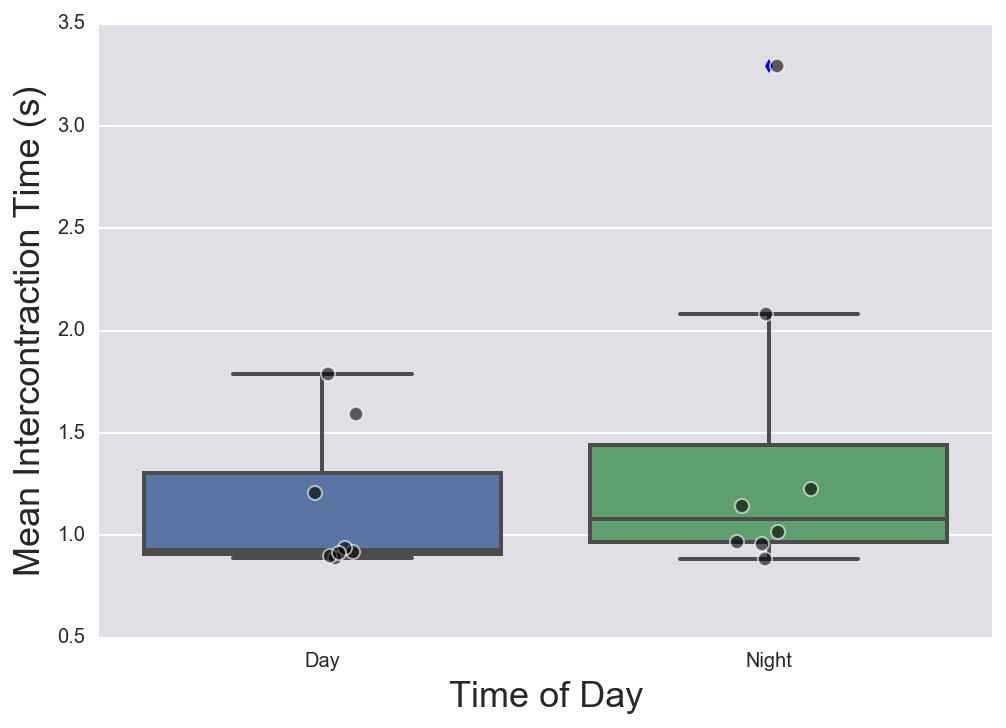

In [140]:
# Make boxplots to compare among individual jellyfish 
df = pd.DataFrame(columns=['Time of Day', 'Mean Intercontraction Time (s)'])
day_list = ['Day'] * 8
night_list = ['Night'] * 8
daynight_list = day_list + night_list
df['Time of Day'] = daynight_list
df['Mean Intercontraction Time (s)'] = np.concatenate((mean_int_day, mean_int_night))

ax = sns.boxplot(x=df['Time of Day'], y=df['Mean Intercontraction Time (s)'])
ax  = sns.stripplot(x=df['Time of Day'], 
                    y=df['Mean Intercontraction Time (s)'], 
                    data=df, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')

In [108]:
a = [1, 2, 3, 4, 5, 6, 7, 8]
len(list(itertools.chain.from_iterable([[a[i]] * len(arr) for i, arr in enumerate(t_int_list_day)])))

1988

In [116]:
len([[jellyfish_nums[i]] * len(arr) for i, arr in enumerate(t_int_list_day)])

8

In [119]:
len(list(itertools.chain.from_iterable([[jellyfish_nums[i]] 
                                                        * len(arr) for i, 
                                                        arr in enumerate(t_int_list_night)])))

1740

In [132]:
x=itertools.chain.from_iterable([[jellyfish_nums[i]]* len(arr) for i, arr in enumerate(t_int_list_day)])

In [133]:
len(list(x))

1988

In [137]:
x=list(itertools.chain.from_iterable([[jellyfish_nums[i]] 
                                                        * len(arr) for i, 
                                                        arr in enumerate(t_int_list_day)])) +\
                    list(itertools.chain.from_iterable([[jellyfish_nums[i]] 
                                                        * len(arr) for i,
                                                        arr in enumerate(t_int_list_night)]))

In [138]:
len(x)

3728